<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Traveling sales person

## Contents

In this notebook, we will learn

- How to parallelize the solution of the traveling sales person problem
- The concept of search overhead
- A dynamic load balancing method


<div class="alert alert-block alert-info">
<b>Note:</b> Do not forget to execute the cell below before starting this notebook! 
</div>

In [ ]:
using Printf
function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done! "
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
tsp_check_2(answer) = answer_checker(answer, 4)
tsp_check_3(answer) = answer_checker(answer, "d")
tsp_check_4(answer) = answer_checker(answer, "a")
function q_superlinear_answer(bool)
    bool || return
    msg = """
    Negative search overhead can explain the superlinear speedup in this algorithm. The optimal speedup (speedup equal to the numer of processors) assumes that the work done in the sequental and parallel algorithm is the same. If the parallel code does less work, it is possible to go beyond the optimal speedup. Cache effects are not likely to have a positive impact here. Even large search spaces can be represented with rather small distance matrices. Moreover, we are not partitioning the distance matrix.
    """
    println(msg)
end
println("🥳 Well done!")

## The traveling sales person (TSP) problem


In this notebook, we will study another algorithm that works with graphs, the [traveling sales person (TSP) problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem). The classical formulation of this problem is as follows (quoted from Wikipedia) "Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once?" This problem has applications in combinatorial optimization, theoretical computer science, and operations research. It is a very expensive problem to solve (NP-hard problem), which makes parallel computing often required.

<div class="alert alert-block alert-info">
<b>Note:</b> There are two key variations of this problem. One in which the sales person returns to the initial city, and another in which the sales person does not return to the initial city. We will consider the second variant for simplicity.
</div>


### Problem statement

Our version of the TSP problem can be formalized as follows. Given a graph $G$ with a distance table $C$ and an initial node  in the graph, compute the shortest route that visits all nodes exactly once, without returning to the initial node. The nodes on the graph can be interpreted as the "cities", and the solution is the optimal route for the traveling salesperson to visit all cities. The following figure shows a simple TSP problem and its solution.

<div>
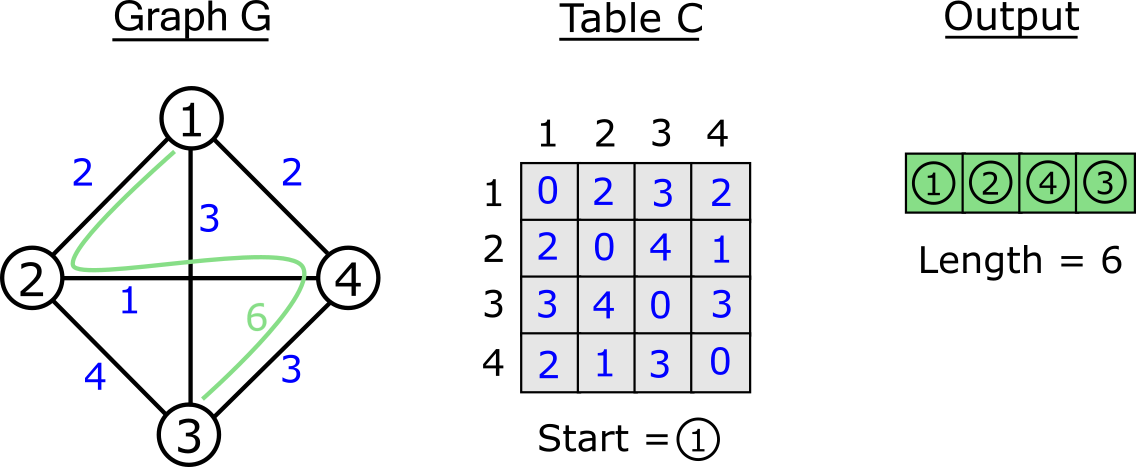
</div>
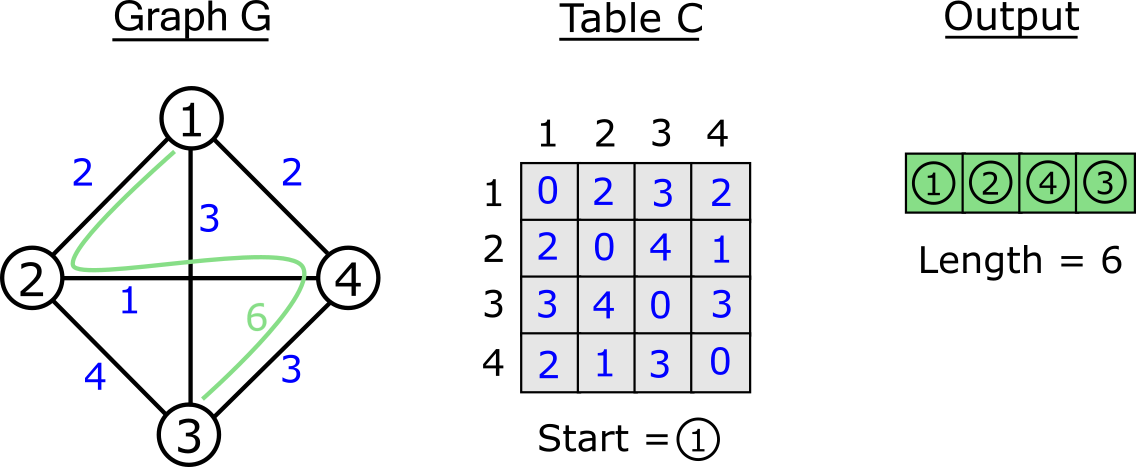

### Sequential algorithm (branch and bound)

A well known method to solve this problem is based on a [branch and bound](https://en.wikipedia.org/wiki/Branch_and_bound) strategy. It consists in organizing all possible routes in a tree-like structure (this is the "branch" part from the branch and bound strategy). The root of this tree is the initial city. The children of each node in the graph are the neighbor cities that have not been visited in the path so far. When all neighbor cities are already visited, the city becomes a leaf node in the tree. See figure below for the tree associated with our TSP problem example. The TSP problem consists now in finding which is the "shortest" branch in this tree. The tree data structure is just a convenient way of organizing all possible routes in order to search for the shortest one checking one by one, from left to right, using a [depth-first search](https://en.wikipedia.org/wiki/Depth-first_search). We refer to it as the *search tree* or the *search space*.

<div>
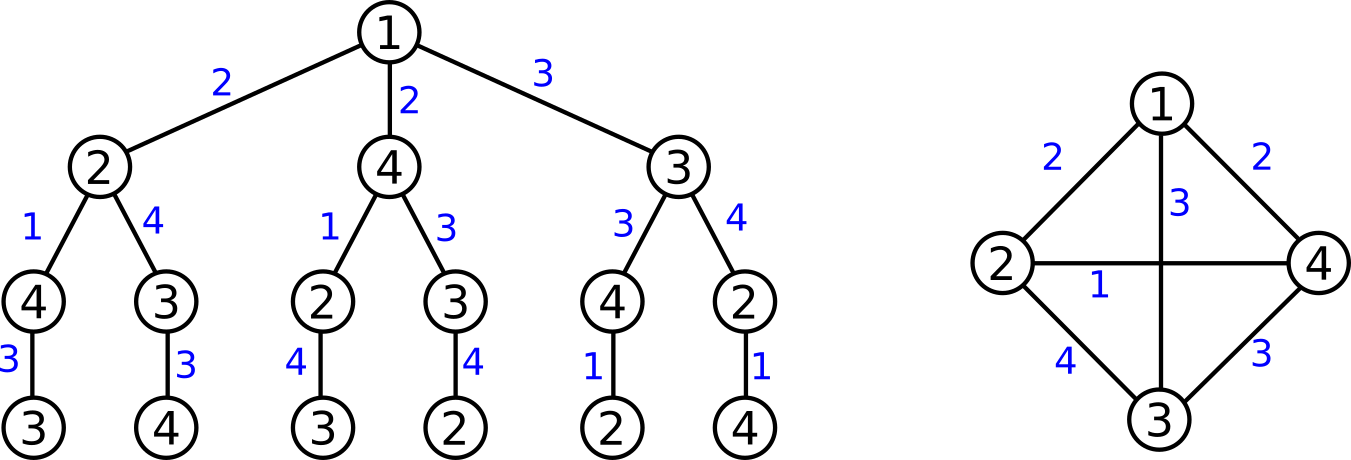
</div>
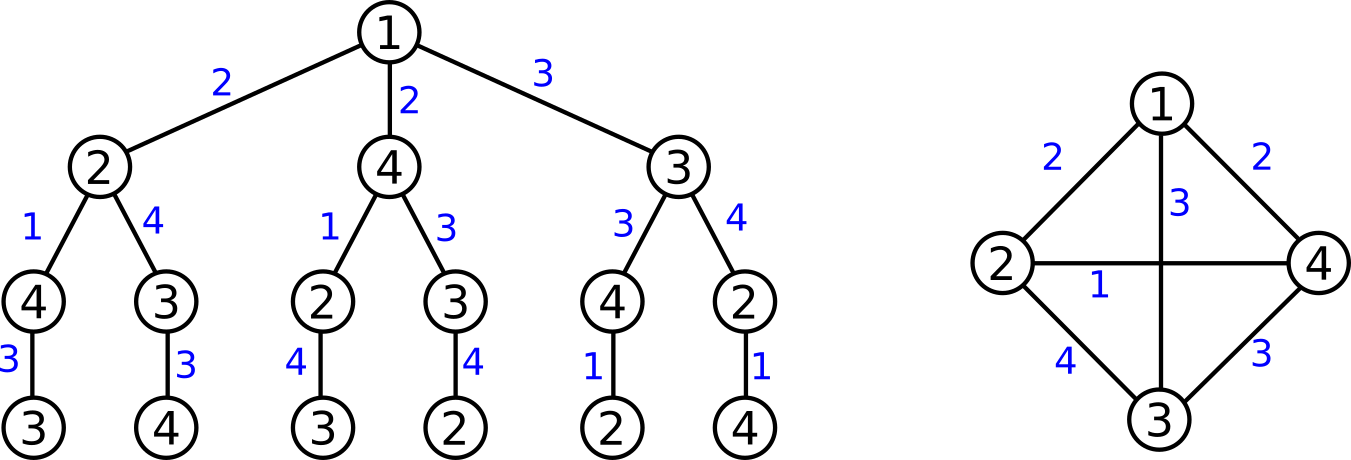

### Nearest city first heuristic

When building the search tree we are free to choose any order when defining the children of a node. A clever order is using the *nearest city first heuristic*. I.e., we sort the children according to how far they are from the current node, in ascending order. This heuristic increases the chances that the the optimal route is located at the left of the tree, which will allow us to speed-up the search using pruning (next section). The figure above used the nearest city first heuristic. In blue you can see the distance between cities. The first child is always the one with the shortest distance.

### Pruning the search tree

The basic idea of the algorithm is to loop over all possible routes (all branches in the search tree) and find find the one with the shortest distance. One can optimize this process by "pruning" the search tree. We visit all possible routes in the tree from left to right. In this process, we keep track of the shortest route visited so far. While visiting a new node in a route, we check if the distance traveled in this route is already larger than the shortest route traversed so far. If this is the case, we can skip all routes that continue from this city as we now for sure that a route will not be in this part of the tree. This is called "pruning" since we are cutting branches of the tree, and is the "bound" part of the branch and bound strategy.  
For example, in the following graph, only 3 out of 6 possible routes need to be fully traversed to find the shortest route. In particular, we do not need to fully traverse the second branch/route (figure below left). When visiting the third city in this branch, the current distance is already equal to the full previous route. It means that the solution will not be in this part of the tree.  In figure below (right), the gray nodes are the ones we do not visit because the minimum distance had been exceeded before completing the route.

<div>
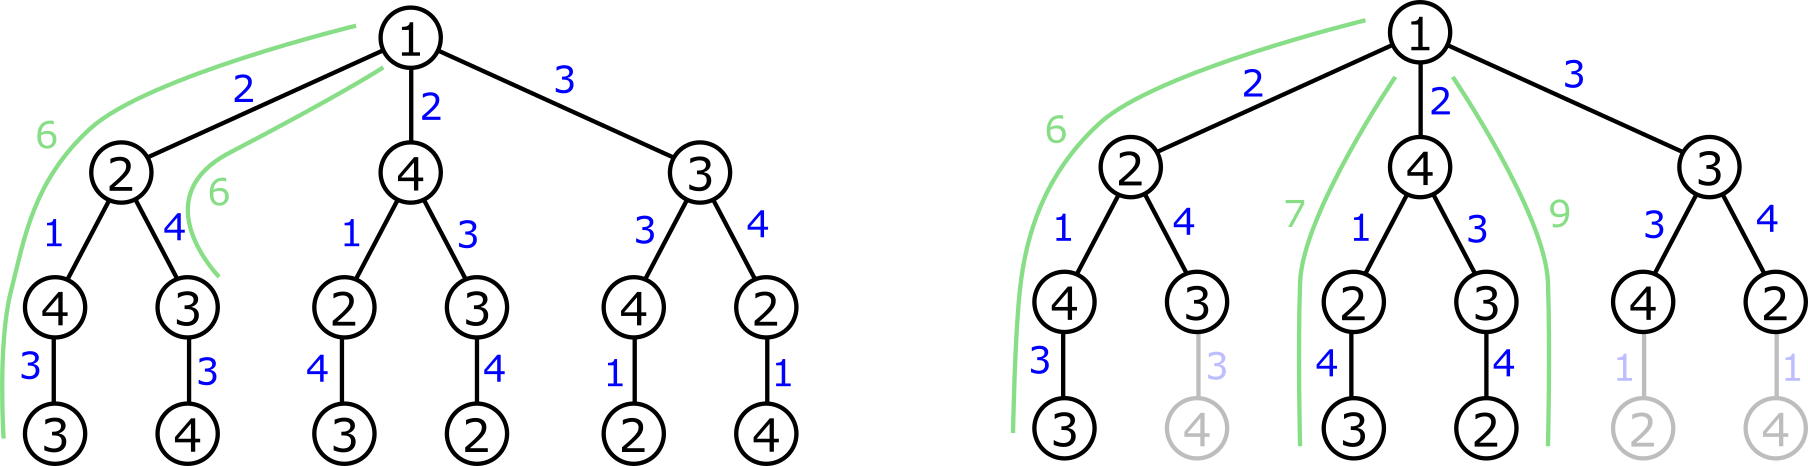
</div>
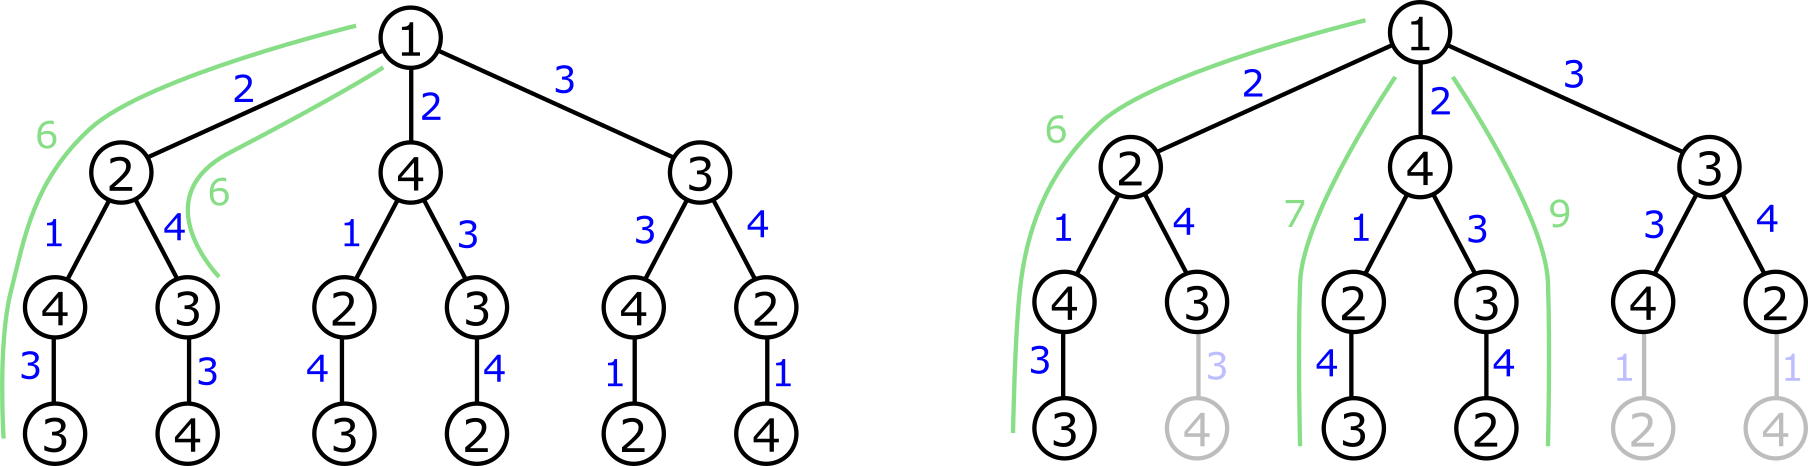

###  Computation complexity

The total number of routes is $O(N!)$, where $N$ is the number of cities. This comes from the fact that the number of possible routes is equal to the number of possible permutations of $N$ cities. Thus the cost of the algorithm is $O(N!)$, which becomes expensive very quickly when $N$ grows.

In practice, however, we will not need to traverse all $O(N!)$ possible routes to find the shortest one since we consider pruning. The nearest city first heuristic also makes more likely that the shortest route is among the first routes to be traversed (left part of the tree), thus increasing the chance to prune routes afterwards. However, the solution can be anywhere in the search tree, and the number of routes to be traversed is $O(N!)$ in the worse case scenario (the optimal route is the right-most one).

## Serial implementation

Let's implement the serial algorithm.


<div class="alert alert-block alert-info">
<b>Note:</b> The implementation of this algorithm is rather challenging. Try to understand the key ideas (the explanations) instead of all code details. Having the complete functional implementation is useful to analyze the actual performance of our parallel implementation at the end of the notebook, and to check if it is consistent with the theory.
</div>

### Nearest-city first heuristic

The first step is preprocessing the distance table to create a new data structure that takes into account the nearest city first heuristic. This is done in the following function.

In [ ]:
function sort_neighbors(C)
    n = size(C,1)
    map(1:n) do i
        Ci = C[i,:]
        cities = sortperm(Ci)
        distances = Ci[cities]
        collect(zip(cities,distances))
    end
end

Execute the next cell to understand the output of `sort_neighbors`.

In [ ]:
C = [
    0 2 3 2
    2 0 4 1
    3 4 0 3
    2 1 3 0    
]
C_sorted = sort_neighbors(C)

The output is a vector of vector of tuples. The outer vector is indexed by a city id, for instance:

In [ ]:
city = 3
C_sorted[city]

 This returns a vector of tuples that contains information about the connections to this city of the form (destination, distance). In this case, city 3 is connected to city 3 at distance 0 (itself), then with city 1 at distance 3, then with city 4 at distance 3, and finally with city 2 at distance 4. Note that the connections  are sorted by their distance in ascending order (here is where the nearest city first heuristic is used). Remember the graph with the distance between cities:

<div>
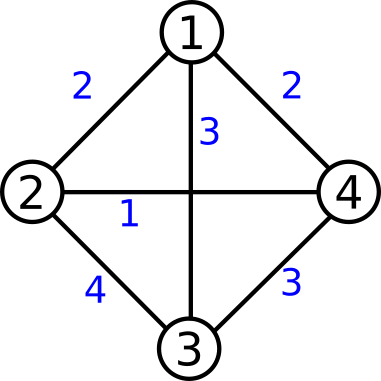
</div>
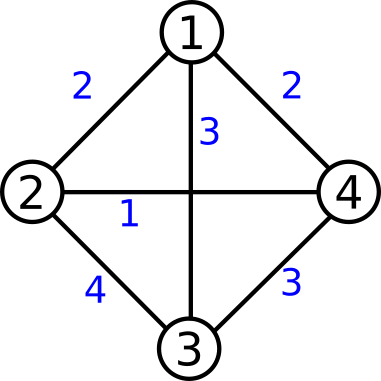

### Loop over all paths

Next, we write an algorithm that traverses the whole search tree and prints all the possible paths. To this end, the tree is traversed in [depth-first order](https://en.wikipedia.org/wiki/Depth-first_search) using a recursive function call. Before we go to a neighbouring city, we also have to verify that it has not been visited on this path yet. If we reach a leaf node, we print the complete path and continue searching.

<div>
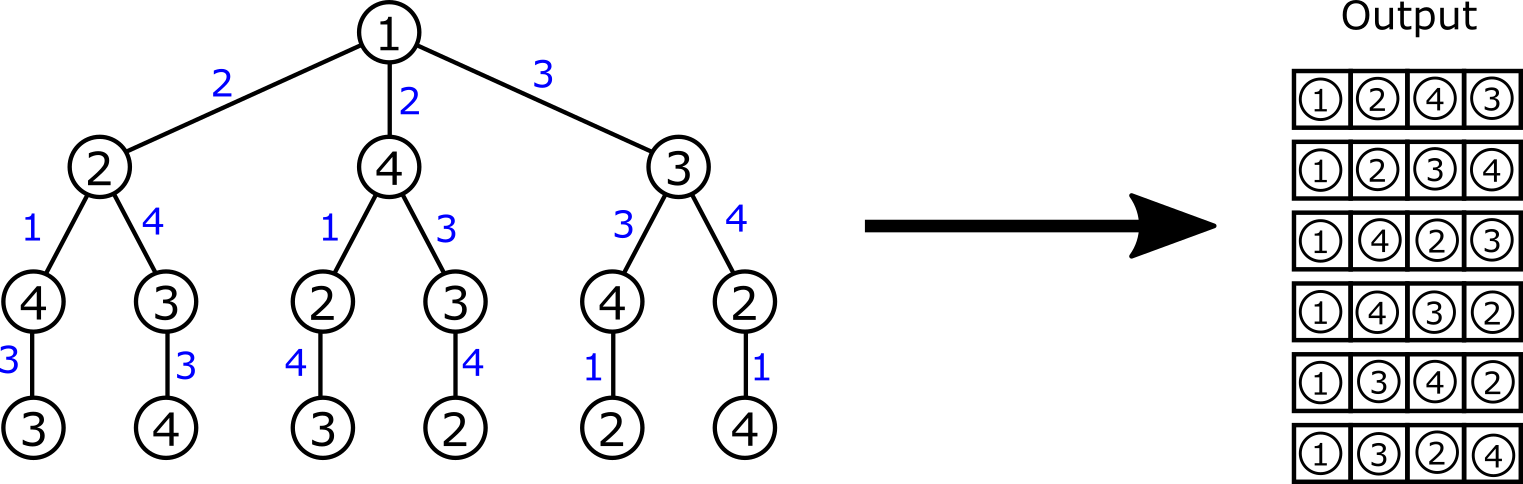
</div>
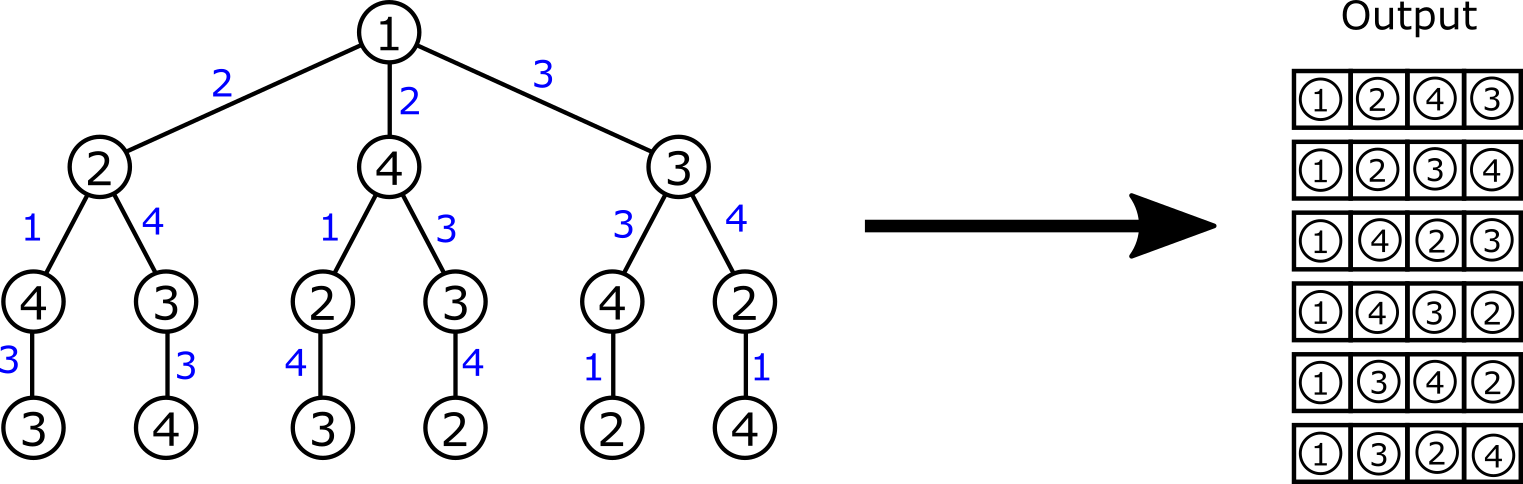

In [ ]:
function visit_all_paths(C_sorted,city)
    # Initialize path
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    visit_all_paths_recursive!(C_sorted,hops,path)
end
function visit_all_paths_recursive!(C_sorted,hops,path)
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        next_hops = hops + 1
        connections = C_sorted[city]
        for (next_city,distance_increment) in connections
            # Check if next_city is already on path
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                path[next_hops] = next_city
                visit_all_paths_recursive!(C_sorted,next_hops,path)
            end
        end
        return nothing
    else
        println("I just completed route $path")
        return nothing
    end
end

In [ ]:
city = 1
visit_all_paths(C_sorted,city)

### Serial implementation without pruning

Now, we know how to traverse all possible routes. We just need a minor modification of the code below to solve the TSP problem (without pruning). We add a new variable called `min_distance` that keeps track of the distance  of the shortest route so-far. This variable is updated at the end of each route, i.e., when a leaf node is visited. After traversing all routes, `min_distance` will contain the distance of the shortest route (the solution of the ASP problem).

<div>
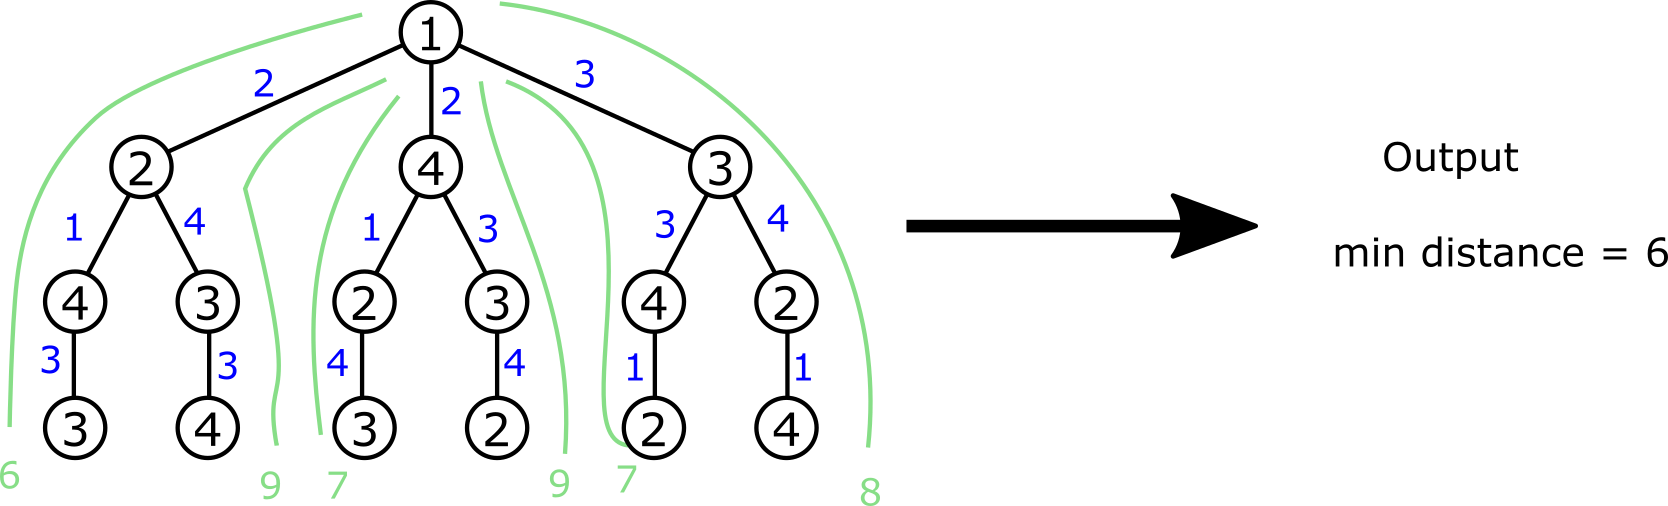
</div>
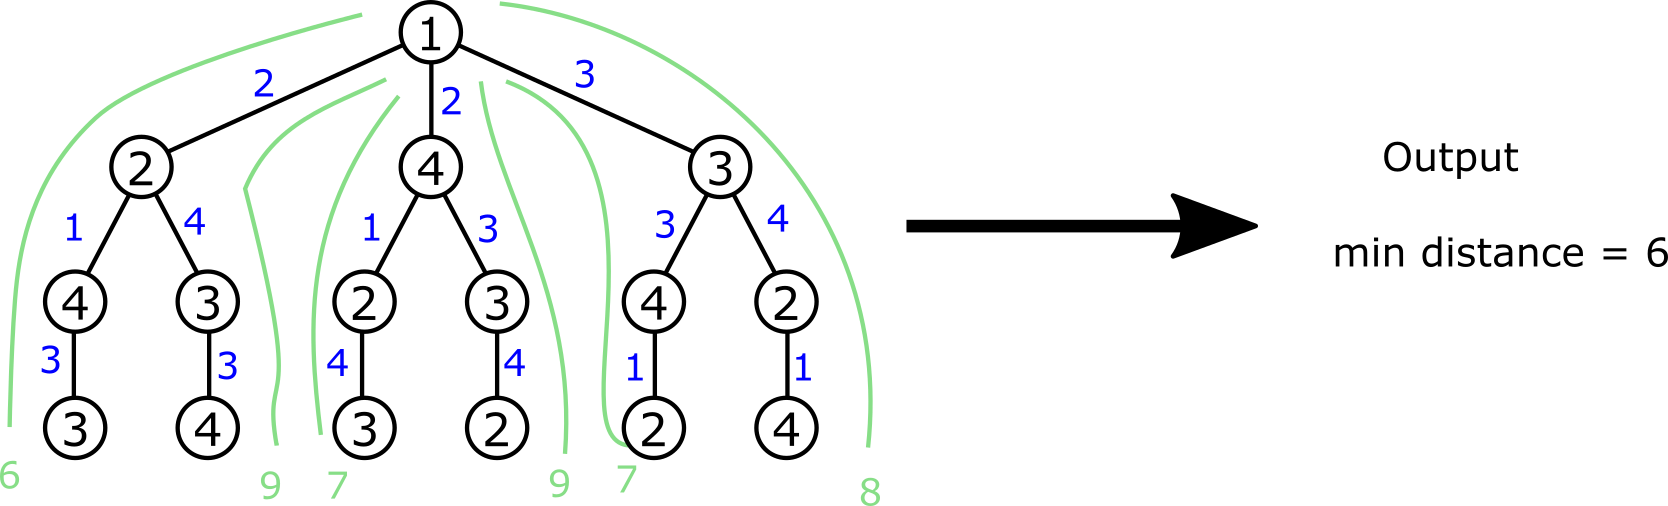

<div class="alert alert-block alert-info">
<b>Note:</b> We could further modify the function so that we also return a vector containing the cities in the shortest route. However, in this notebook, we will only return the distance of the shortest route (a single value) for simplicity.
</div>

In [ ]:
verbose::Bool = true
function tsp_serial_no_prune(C_sorted,city)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    distance=0
    min_distance = typemax(Int)
    tsp_serial_no_prune_recursive!(C_sorted,hops,path,distance,min_distance)
end
function tsp_serial_no_prune_recursive!(C_sorted,hops,path,distance,min_distance)
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        next_hops = hops + 1
        connections = C_sorted[city]
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                # Add new city to path
                next_distance = distance + distance_increment
                path[next_hops] = next_city
                min_distance = tsp_serial_no_prune_recursive!(
                    C_sorted,next_hops,path,next_distance,min_distance)
            end
        end
        return min_distance
    else
        # Set new minimum distance in leaf nodes
        min_distance = min(distance,min_distance)
        verbose && println("I just completed route $path. Min distance so far is $min_distance")
        return min_distance
    end
end

In [ ]:
city = 1
verbose = true
min_distance = tsp_serial_no_prune(C_sorted,city)

### Final serial implementation

Finally, we add the pruning to our algorithm. Anytime the current distance exceeds the minimum distance, the search in this path is aborted and continued with another path. By running the function below, you will see that only three routes will be traversed thanks to pruning as shown in next figure.

<div>
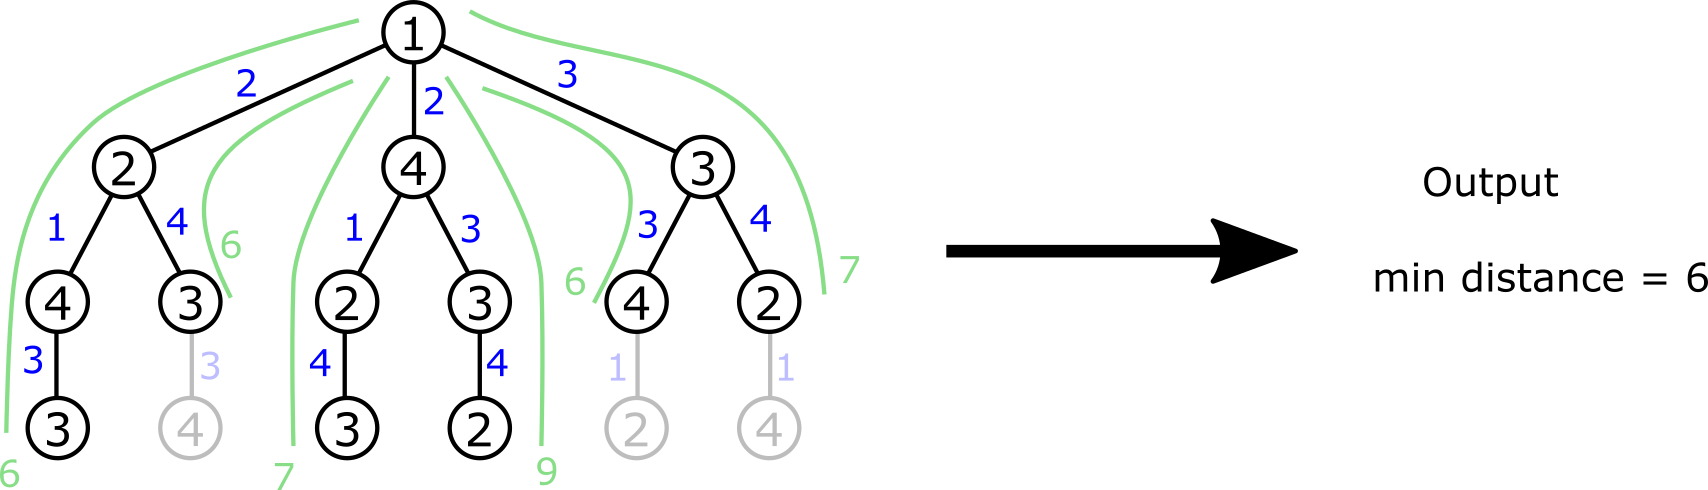
</div>
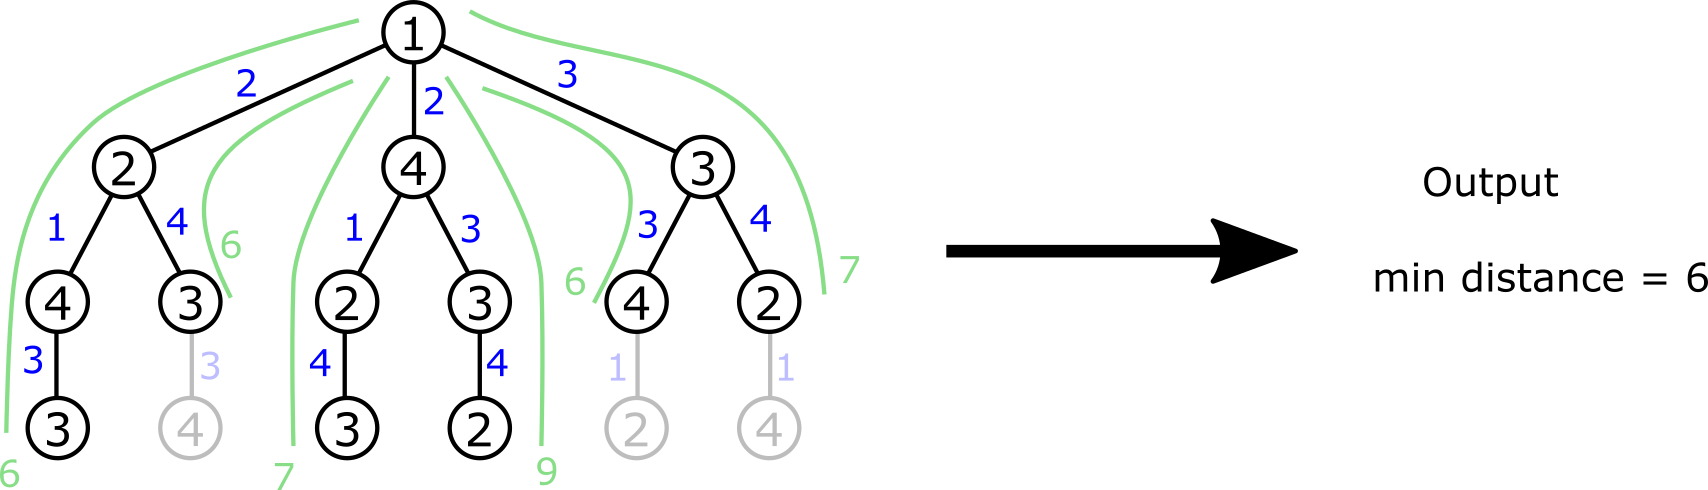

In [ ]:
function tsp_serial(C_sorted,city)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    distance=0
    min_distance = typemax(Int)
    tsp_serial_recursive!(C_sorted,hops,path,distance,min_distance)
end
function tsp_serial_recursive!(C_sorted,hops,path,distance,min_distance)
    # Prune this path if its distance is too high already
    if distance >= min_distance
        verbose && println("I am pruning at $(view(path,1:hops))")
        return min_distance
    end
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                # Add city to path 
                next_distance = distance + distance_increment
                path[next_hops] = next_city
                min_distance = tsp_serial_recursive!(
                    C_sorted,next_hops,path,next_distance,min_distance)
            end
        end
        return min_distance
    else
        # Set new minimum distance in leaf nodes
        min_distance = min(distance,min_distance)
        verbose && println("I just completed route $path. Min distance so far is $min_distance")
        return min_distance
    end
end

In [ ]:
city = 1
verbose = true
min_distance = tsp_serial(C_sorted,city)

### Performance
Let's have a look at how well our code performs. In the following block, we create another random matrix and time the execution for both versions with and without pruning. 

In [ ]:
n = 11 # It is safe to test up to n=11 on a laptop
using Random
using Test
Random.seed!(1)
C = rand(1:10,n,n)
C_sorted = sort_neighbors(C)
city = 1
verbose = false
@time min_no_prune = tsp_serial_no_prune(C_sorted,city)
@time min_prune = tsp_serial(C_sorted,city)
@test min_no_prune == min_prune

You can observe that, especially for larger numbers of cities (n=11), the performance of the algorithm with pruning is much better than the performance of the algorithm without pruning. 

## Parallel algorithm

### Where can we extract parallelism ?

All branches of the search tree can be traversed in parallel. Let us discuss how we can distribute these branches over several processes.



<div>
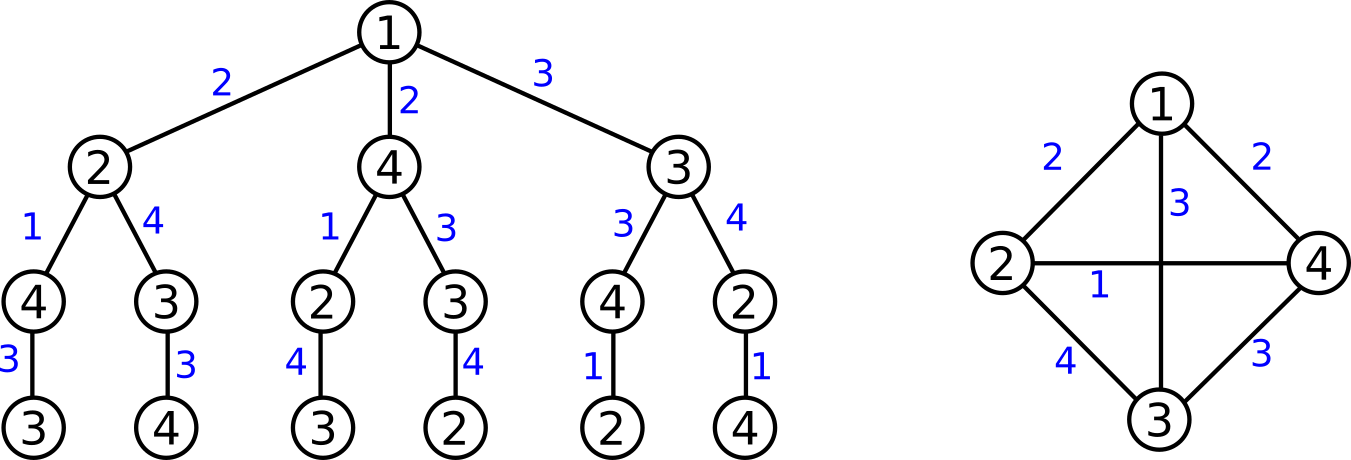
</div>
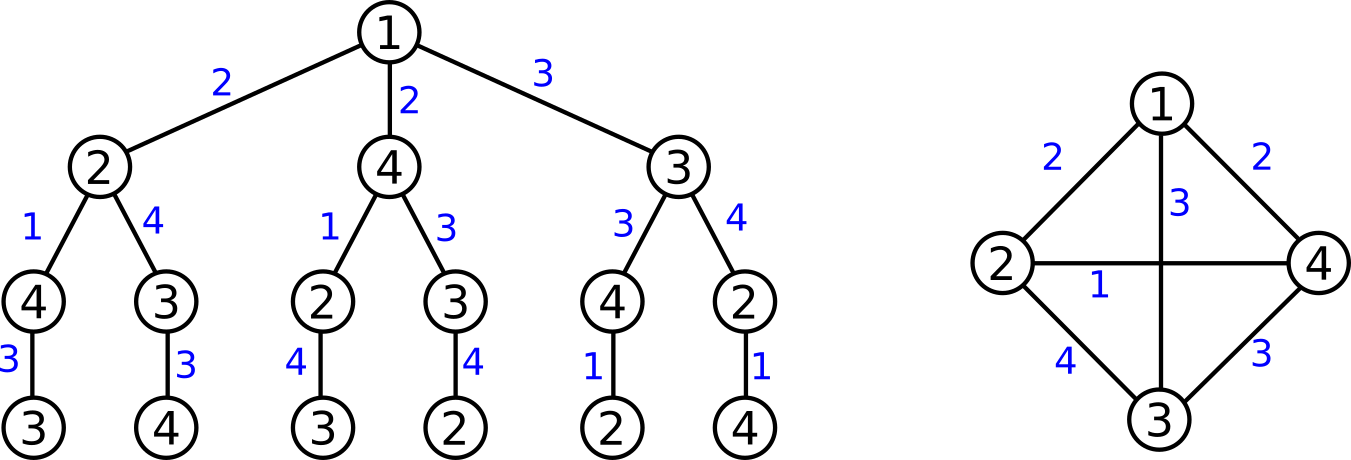

### Option 1

We can (at least in theory)  assign a branch of our search tree to each process. However, as mentioned in an earlier section, the number of branches in the search tree can be up to $O(N!)$. This would require an unfeasibly large amount of processors which each do only very little work. Thus, we skip this option as it is impractical.

<div>
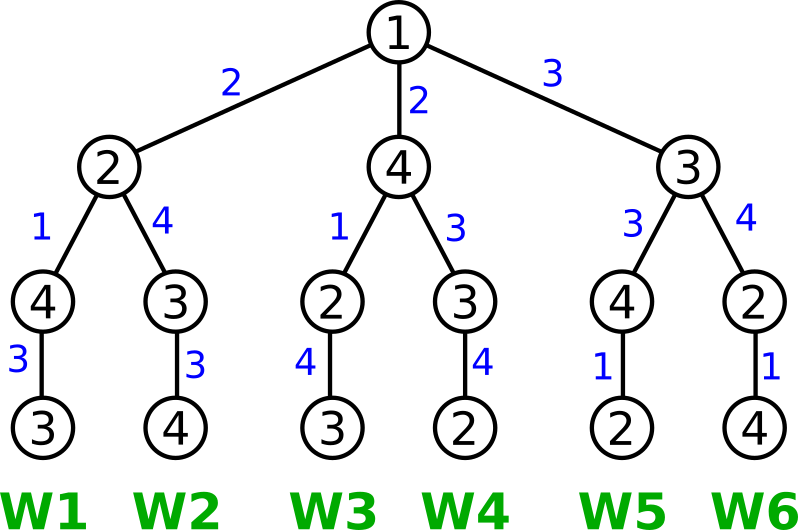
</div>
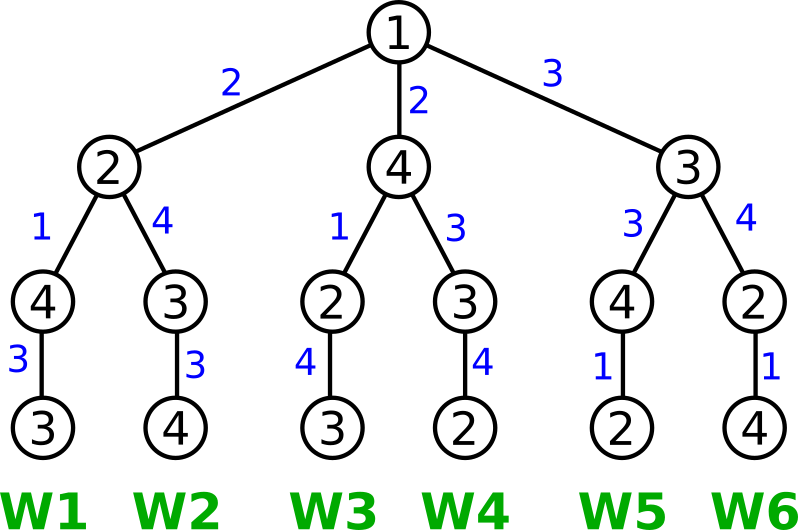

### Option 2

Instead of assigning one branch per worker, we can assign a fixed number of branches to each worker. This would be a good strategy if we do not consider pruning. However, it is not efficient if we include pruning (which is essential in this algorithm). 

<div>
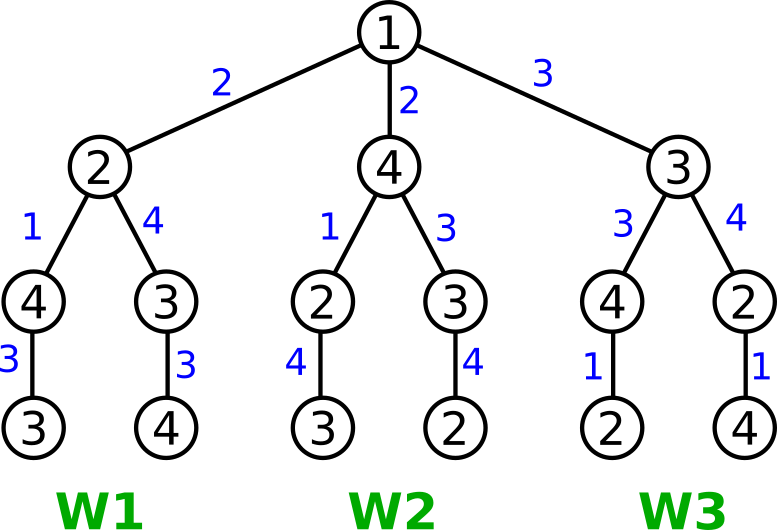
</div>
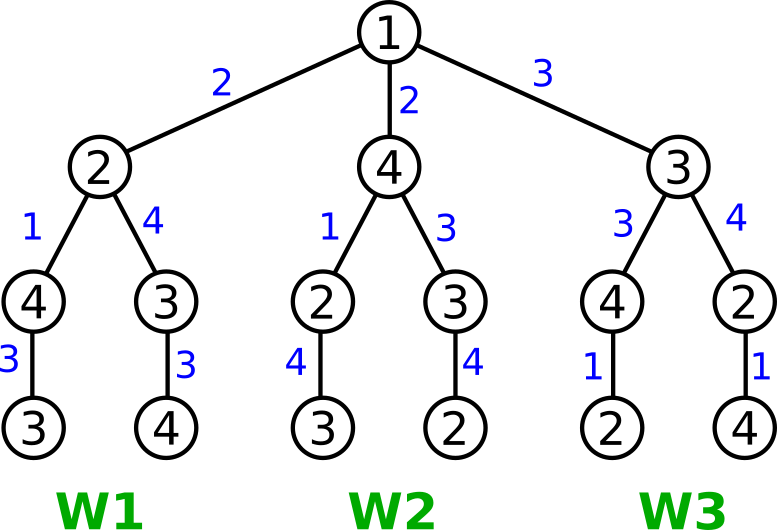

### Performance issues:  Load balance

Pruning is essential in this algorithm but makes challenging to evenly distribute the work over available processors. Image that we assign the same number of branches per worker and that the workers use pruning locally to speed up the solution process. It is not possible to know in advance how many branches will be fully traversed by each worker since pruning depends on the values in the input distance matrix (runtime values). It might happen that a worker can prune many branches and finishes fast, whereas other workers are not able to prune so many branches and they need more time to finish. This is a clear example of bad load balance. We will explain a strategy to fix it later in the notebook.


### Performance issues: Search overhead 

Another disadvantage of this kind of parallel search is that the pruning is now less effective. The workers each run their own version of the search algorithm and keep track of their local minimum distances, which are  different from the global minimum found so far. This means that less nodes will be pruned in the parallel version than in the serial version. The parallel code might search more routes than the sequential ones. This is called *search overhead*.

<div class="alert alert-block alert-success">
<b>Question:</b> How many routes are fully traversed in total when we assign two branches to each worker? Look at the illustration below. Assume that each worker does pruning locally and independently of the other workers.
</div>

<div>
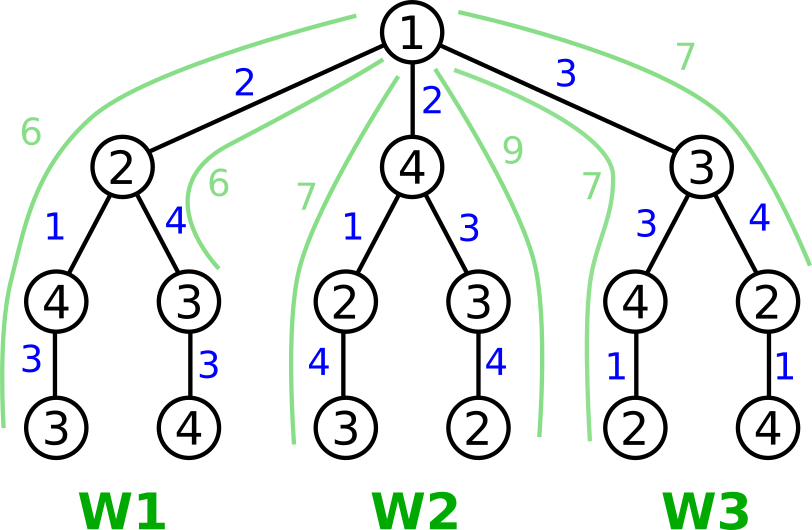
</div>
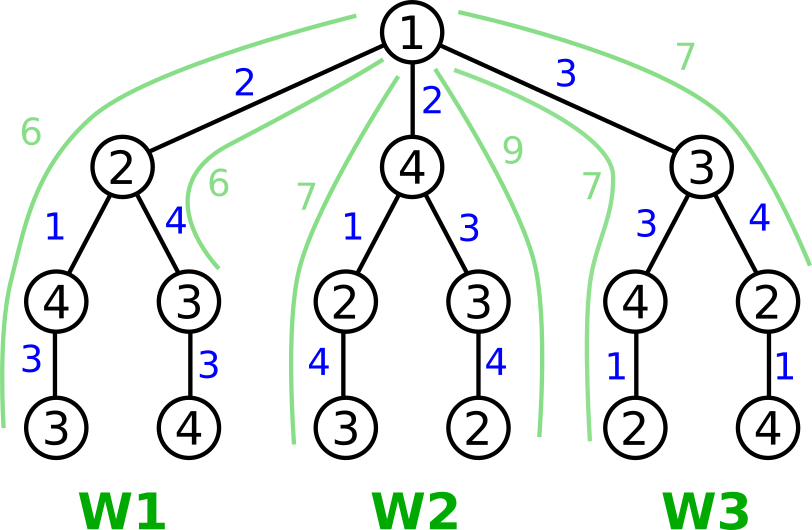

In [ ]:
answer = -1 # Replace with any integer value 
tsp_check_2(answer)

In this example, the parallel algorithm traverses more routes (1 more) then the serial version because not all workers are able to use the global minimum distance as a pruning bound. Remember that the sequential code only traverses 3 routes completely. See figure:

<div>
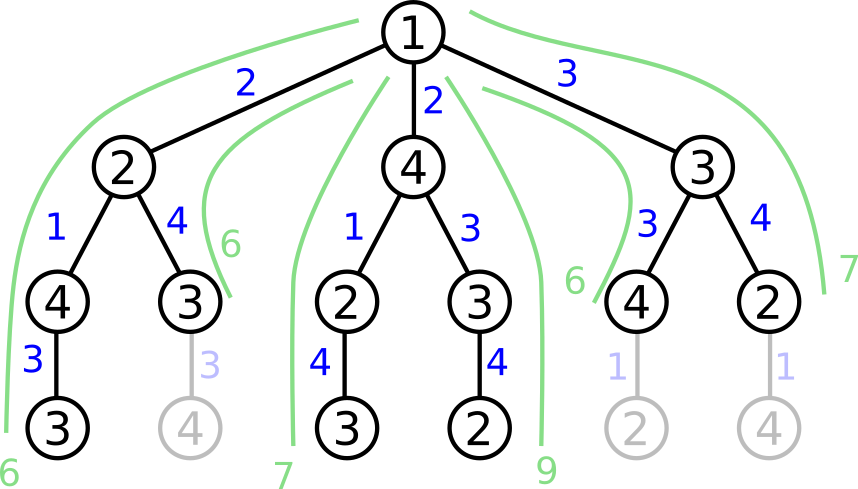
</div>
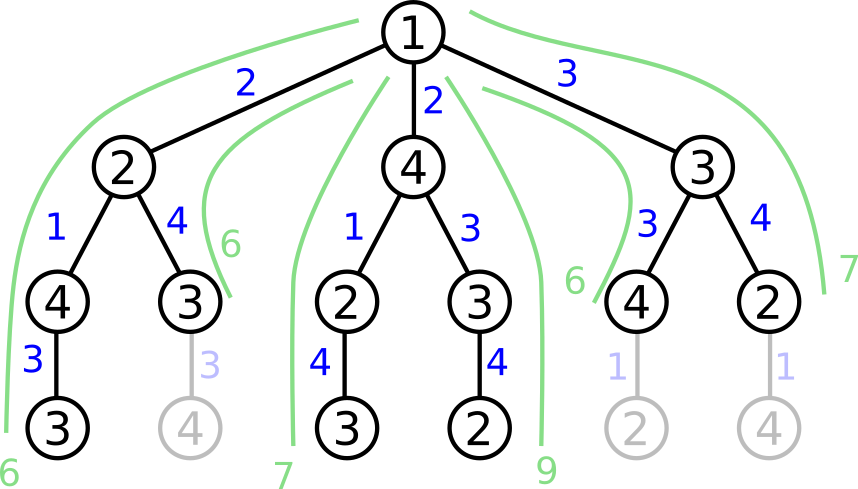

In order to minimize search overhead, workers need to collaboratively keep track of a global minimum distance. However, this needs to be done carefully to avoid race conditions. We show how to do this later in the notebook.

### Negative search overhead

The parallel algorithm might search more branches than the sequential one when we parallelize the pruning process. However, it is also possible that parallel algorithm searches less branches that the sequential one for particular cases. Imagine that the optimal route is on the right side of the tree (or the last route in the tree in the limit case). The parallel algorithm will need less work than the sequential one in this case. The last workers might find the optimal route very quickly and inform the other workers about the optimal minimum, which can then prune branches very effectively. Whereas the sequential algorithm will need to traverse many branches in order to reach the optimal one. If the parallel code does less searches than the sequential one, we say that the search overhead is negative. 

Negative search overhead is very good for parallel speedups, but it depends on the input values. We cannot rely on it to speed up the parallel execution of the algorithm.

### Option 3: Dynamic load balancing with replicated workers model

In this third option, we explain a strategy to improve load balance based using the [*replicated workers model*](https://en.wikipedia.org/wiki/Thread_pool) also known as *worker pool* or *thread pool*. In this model, the main processes (aka master or coordinator process) sends jobs to a job queue. Then, workers take one available job from the queue, run it, and take a new job when they are done. In this process, workers never wait for other workers thus fixing the load balance problem. It does not matter if there are some jobs that are larger than others as long as there are enough jobs to keep the workers busy. The main limiting factor of this model is the number of jobs and speed in which the main process is able to generate jobs and send them to the queue. This is an example of **dynamic load balancing**: the load is distributed among the workers at runtime.


In our parallel implementation, we will use a coordinator process and several worker processes. The coordinator process will search the tree up to a certain maximum depth given by a number of hops/levels _maxhops_. When _maxhops_ is reached, the coordinator will stop searching the tree and will let any available worker to continue searching in the subtree. In the figure below, the master process will only visit the nodes in the top green box. The worker processes will search in parallel the subtrees below.







<div>
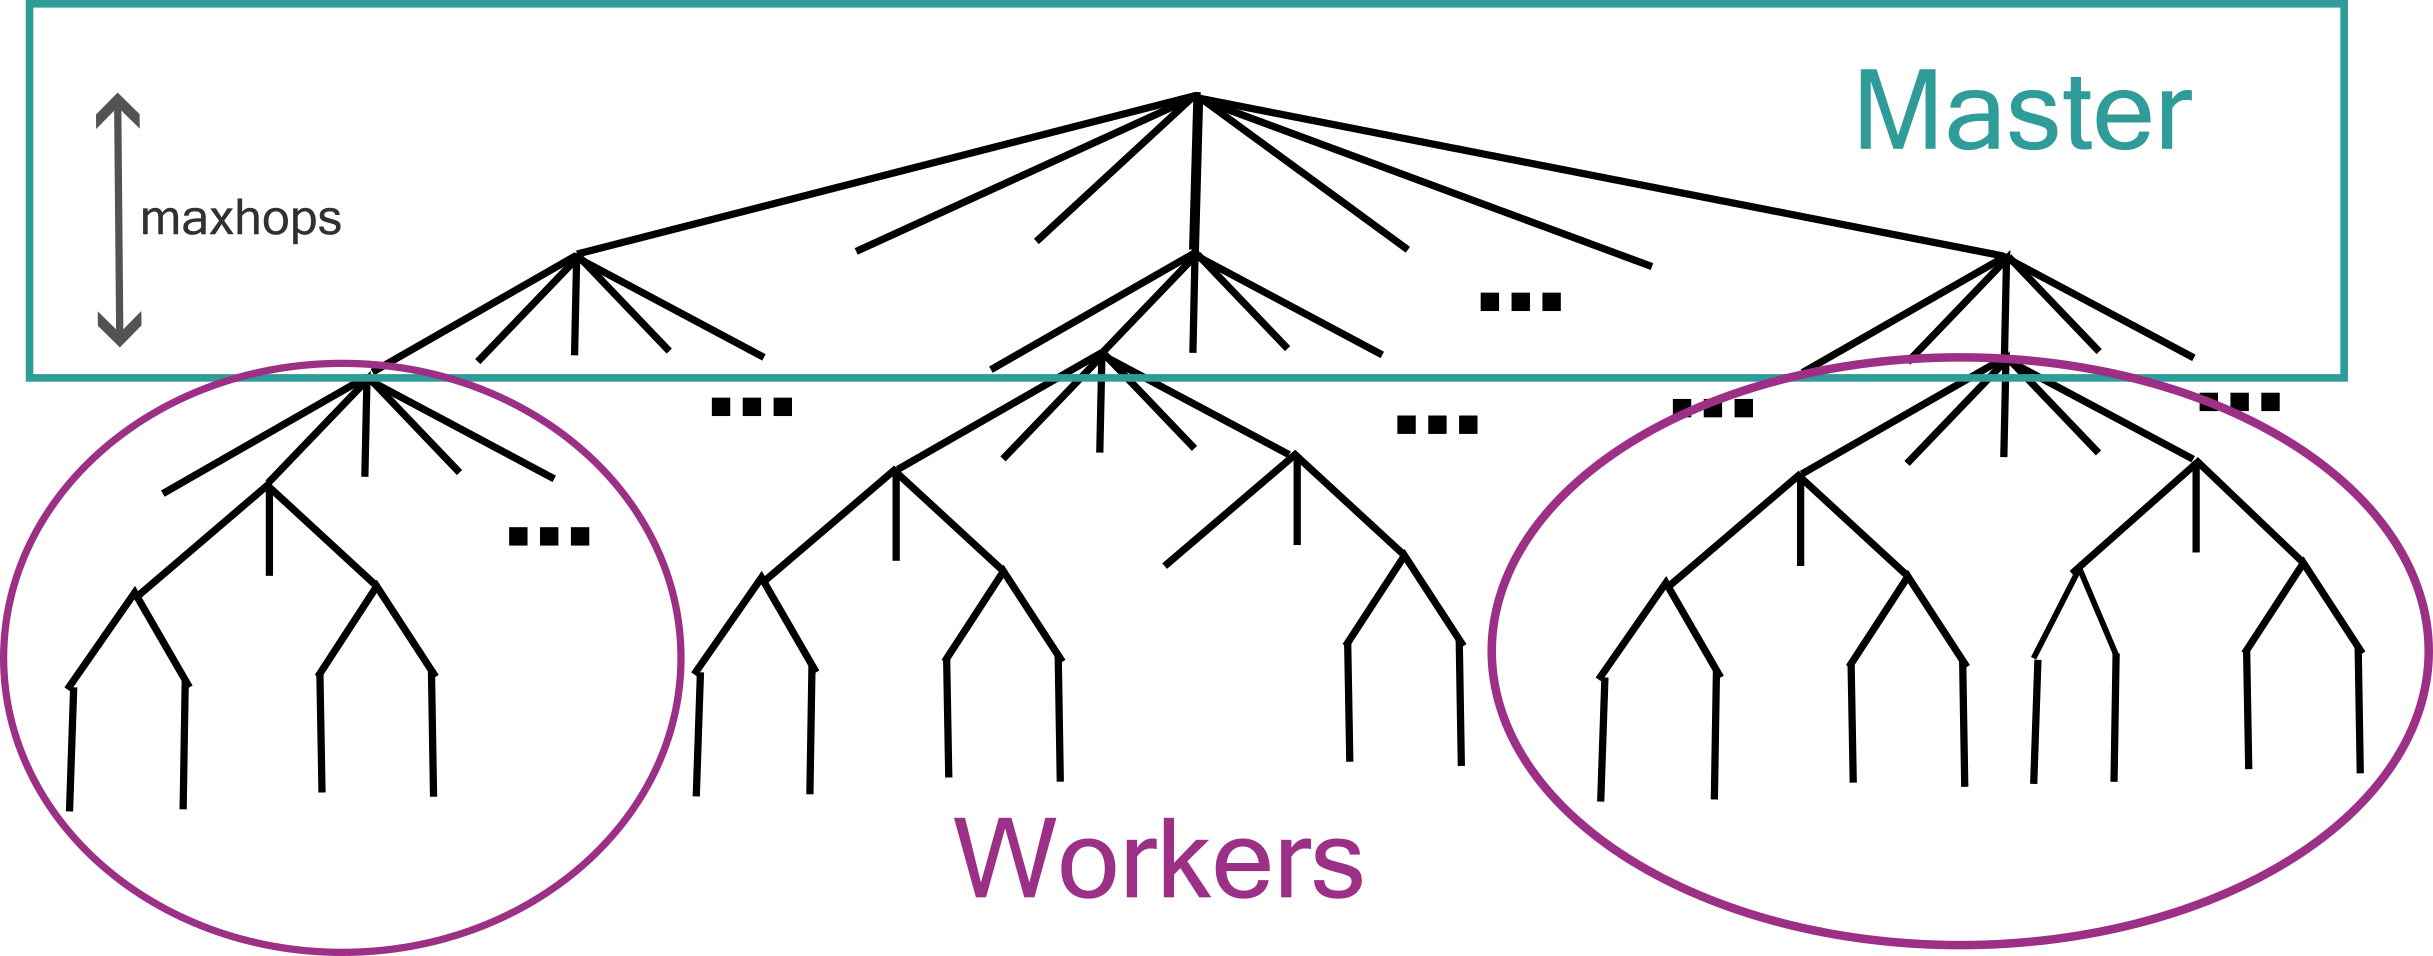
</div>
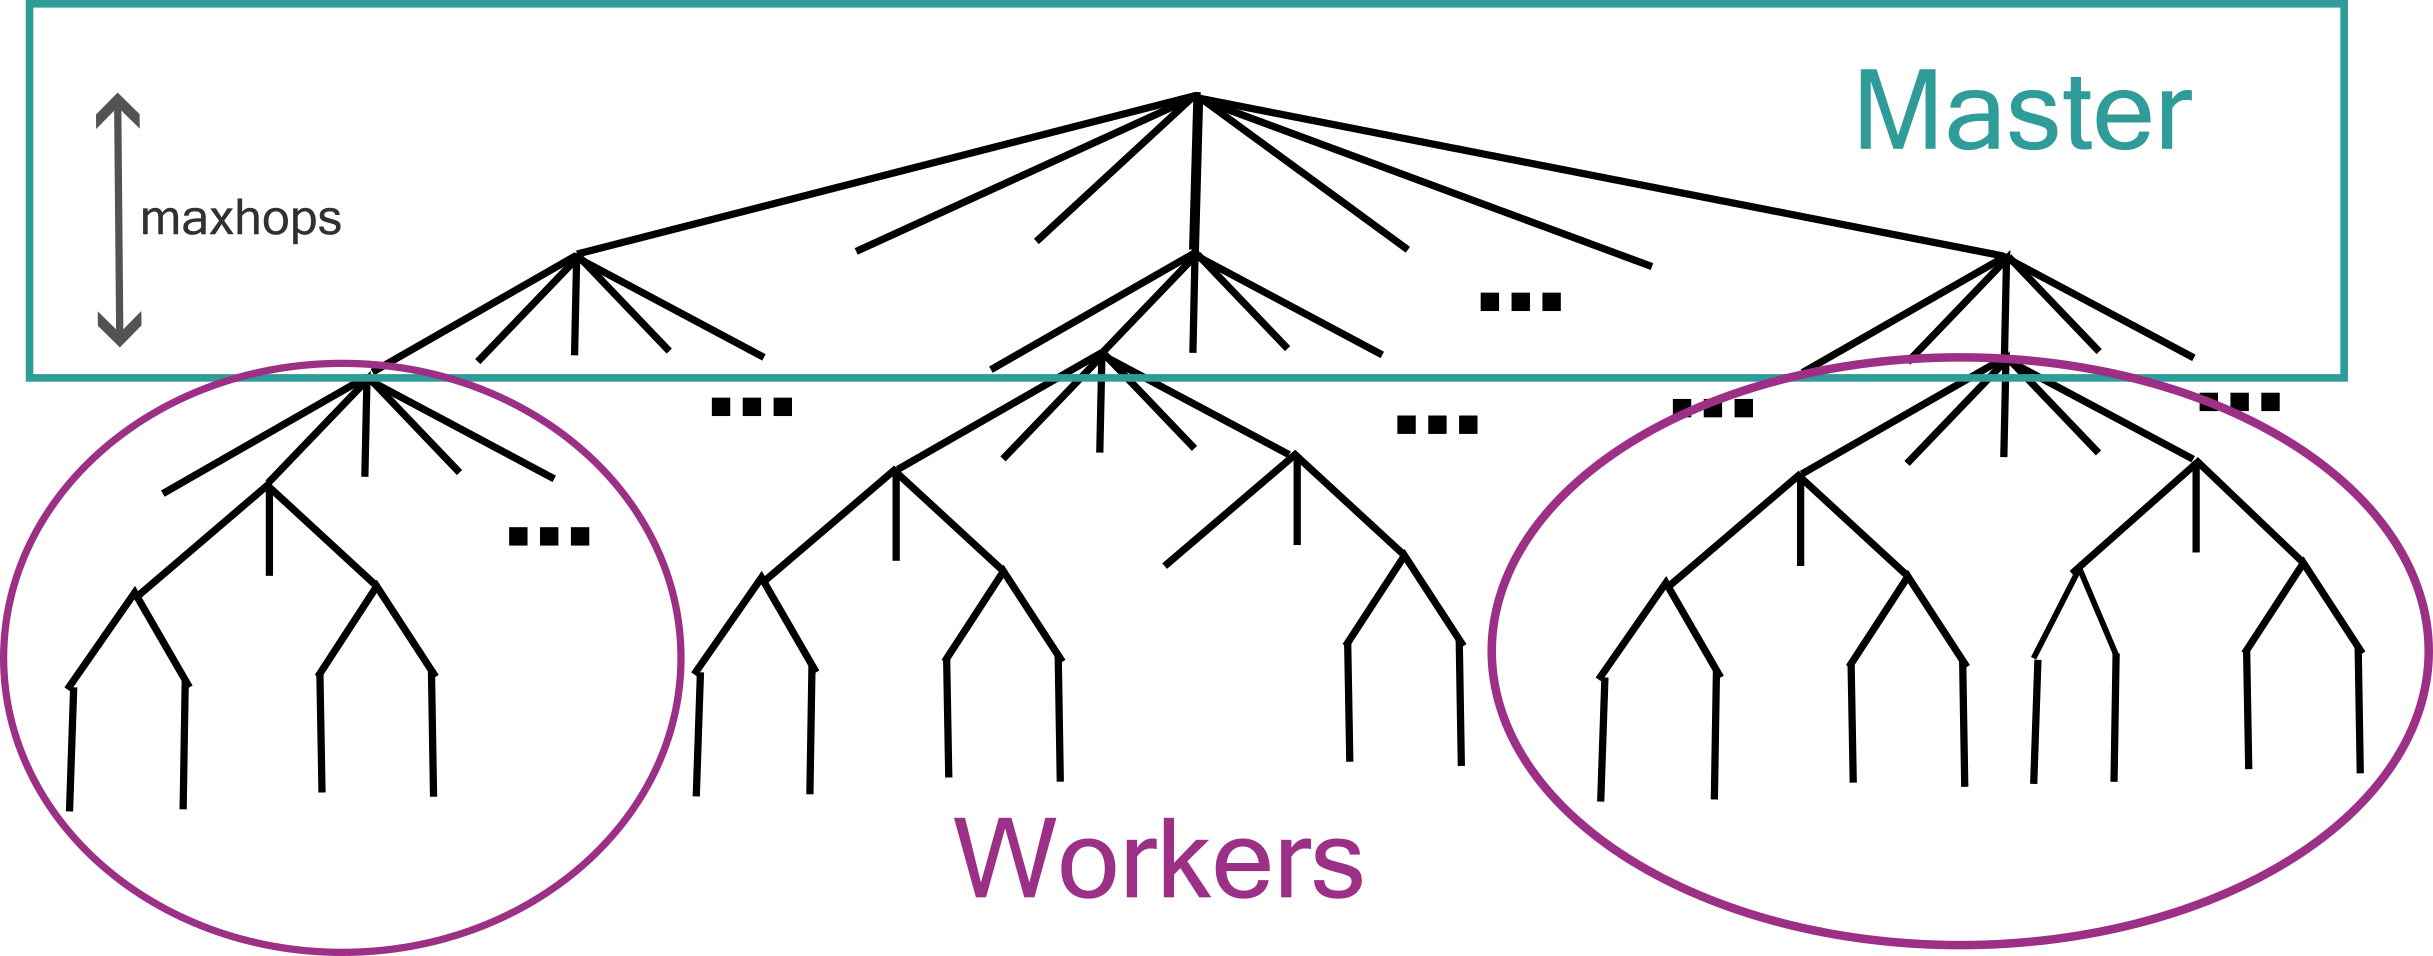

This avoids the performance issues of the previous approach: the workers are not idle since they get new work every time they finish a job. To avoid the search overhead, it is also important that the workers communicate the minimum distance each time they update their local minimum distance. 

### Performance impact of  maxhops

We introduced a new parameter `maxhops`.  Which is then the optimal value for it? When choosing `maxhops`, there is a trade off between load balance and communication overhead.

- A small `maxhops` will reduce the number of jobs communicated to the workers (less communication), but reducing the number of jobs is bad for load balance. In the limit, we might generate even less jobs than the number of workers.

- A large `maxhops` will increase the number of parallel jobs, improving dynamic load balance, but it will lead to more communication.


The optimal value of `maxhops` will depend on the given system, the number of workers, problem size, and also the particular input values. It is not possible to determine it in advance.

## Implementation of the parallel algorithm 

We will implement this algorithm using the task-based programming model provided by Distributed.jl as it is convenient to implement the replicated workers model.

First, let's add our worker processes. 

In [ ]:
using Distributed

In [ ]:
if workers() == procs()
    addprocs(3)
end

### Visit paths in parallel

Next we will write a simplified version of the algorithm which visits all paths in parallel. The communication between the workers and the coordinator is implemented using a `RemoteChannel`. The coordinator calls the function `generate_jobs` which recursively traverses the search tree until _maxhops_ is reached. Then, it copies the current path to the channel. The workers repeatedly take jobs from the channel until the channel is empty. The workers receive the path from the job and continue the search. When they reach a leaf node in the search tree, they print the path.

In [ ]:
function visit_all_paths_dist(C_sorted,city,max_hops)
    T = typeof((0,Int[]))
    jobs_chnl = RemoteChannel(()->Channel{T}(1))
    @sync begin
        for w in workers()
            @spawnat w consume_jobs(C_sorted,jobs_chnl)
        end
        generate_jobs(C_sorted,city,max_hops,jobs_chnl)
        close(jobs_chnl)
    end
end
function generate_jobs(C_sorted,city,max_hops,jobs_chnl)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl)
end
function generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl)
    num_cities = length(C_sorted)
    if hops == max_hops
        @show path
        put!(jobs_chnl,(hops,copy(path)))
        return nothing
    else
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                path[next_hops] = next_city
                generate_jobs_recursive(C_sorted,next_hops,path,max_hops,jobs_chnl)
            end
        end
        return nothing
    end
end
@everywhere function consume_jobs(C_sorted,jobs_chnl)
    while true
        try
            hops,path = take!(jobs_chnl)
            consume_jobs_recursive(C_sorted,hops,path)
        catch
            break
        end        
    end
end
@everywhere function consume_jobs_recursive(C_sorted,hops,path)
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            if ! already_visited
                path[next_hops] = next_city
                consume_jobs_recursive(C_sorted,next_hops,path)
            end
        end
        return nothing
    else
        @show path
        return nothing
    end
end

In [ ]:
C = [
    0 2 3 2
    2 0 4 1
    3 4 0 3
    2 1 3 0    
]
C_sorted = sort_neighbors(C)
city = 1
max_hops = 2
min_distance = visit_all_paths_dist(C_sorted,city,max_hops)

### How to track the global minimum distance?

<div>
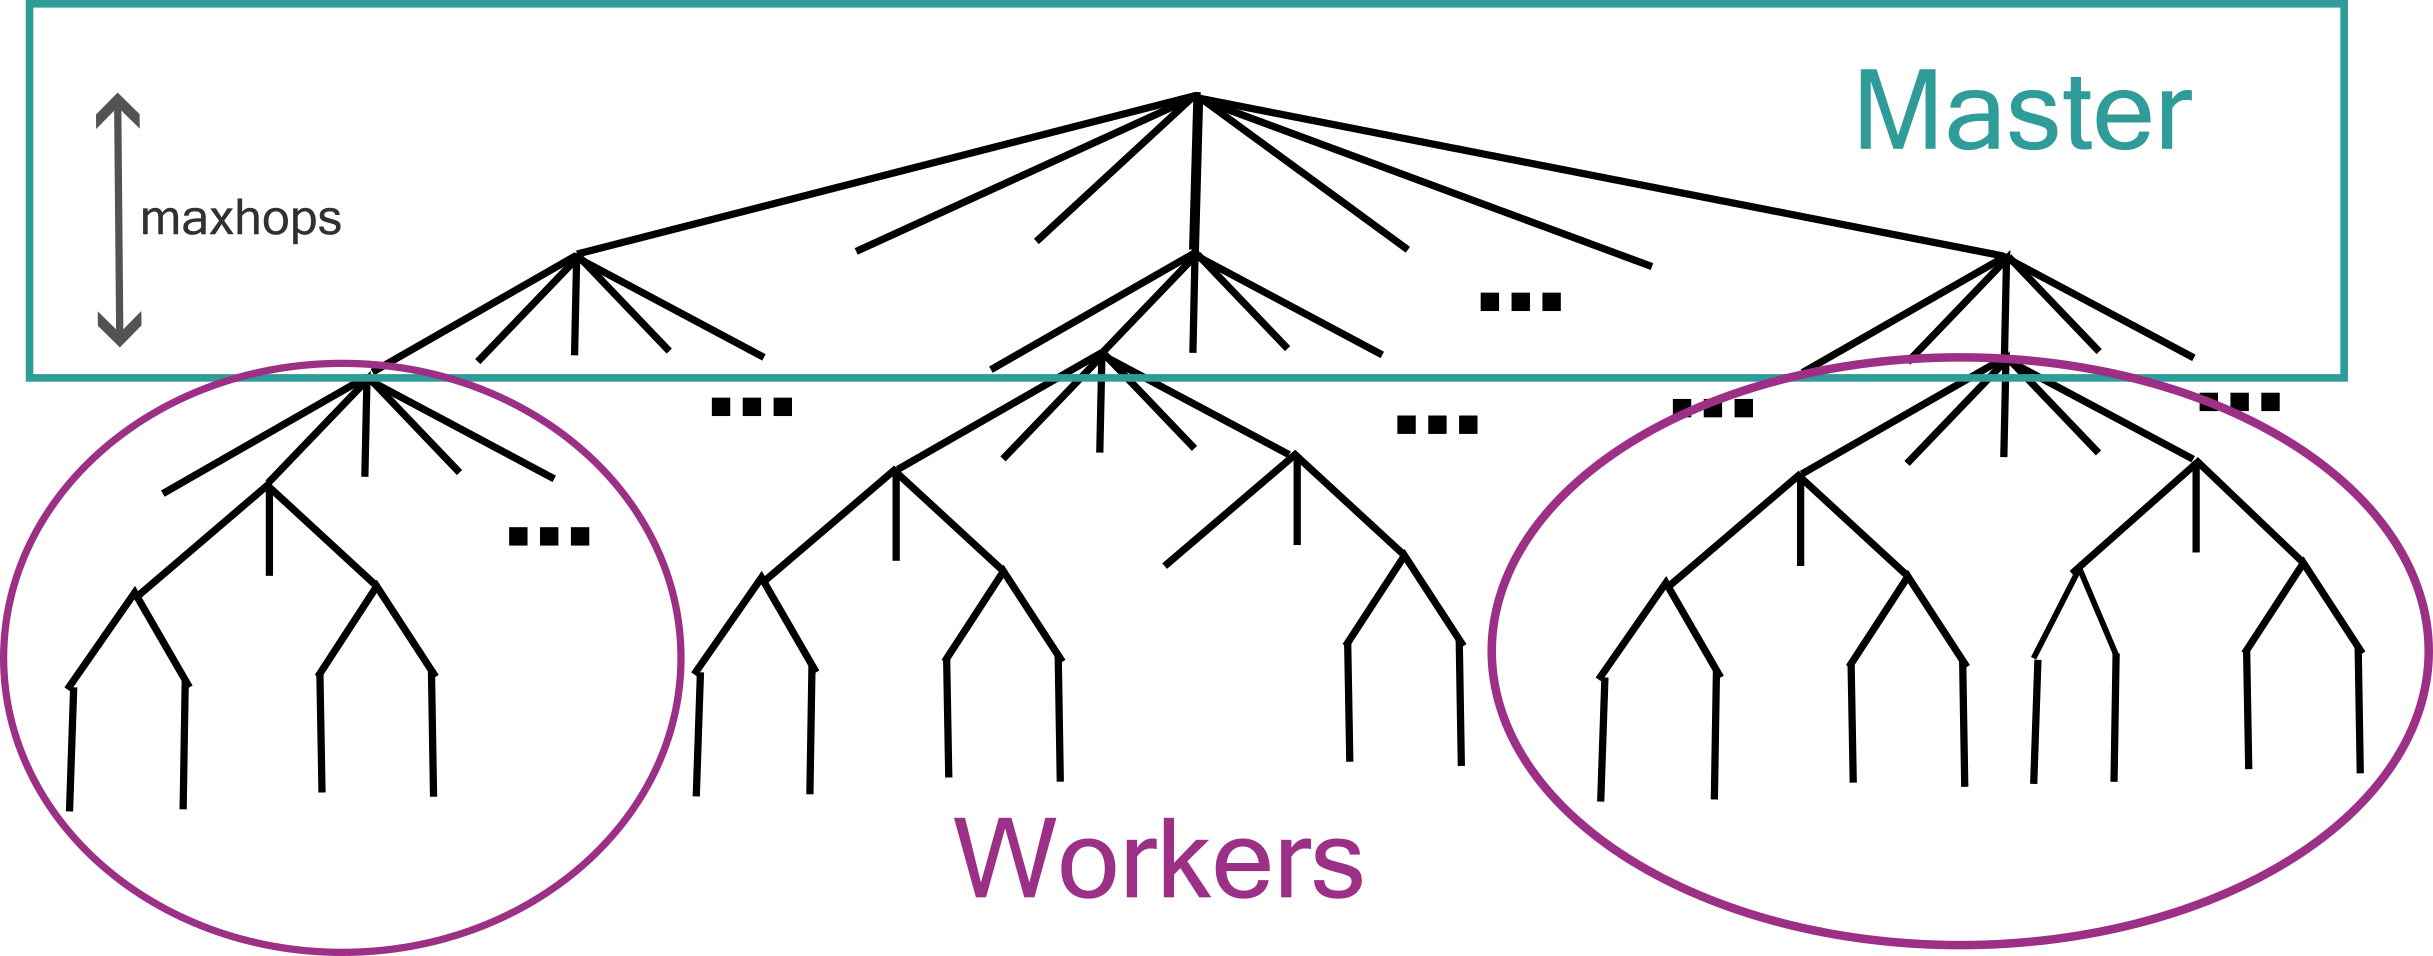
</div>
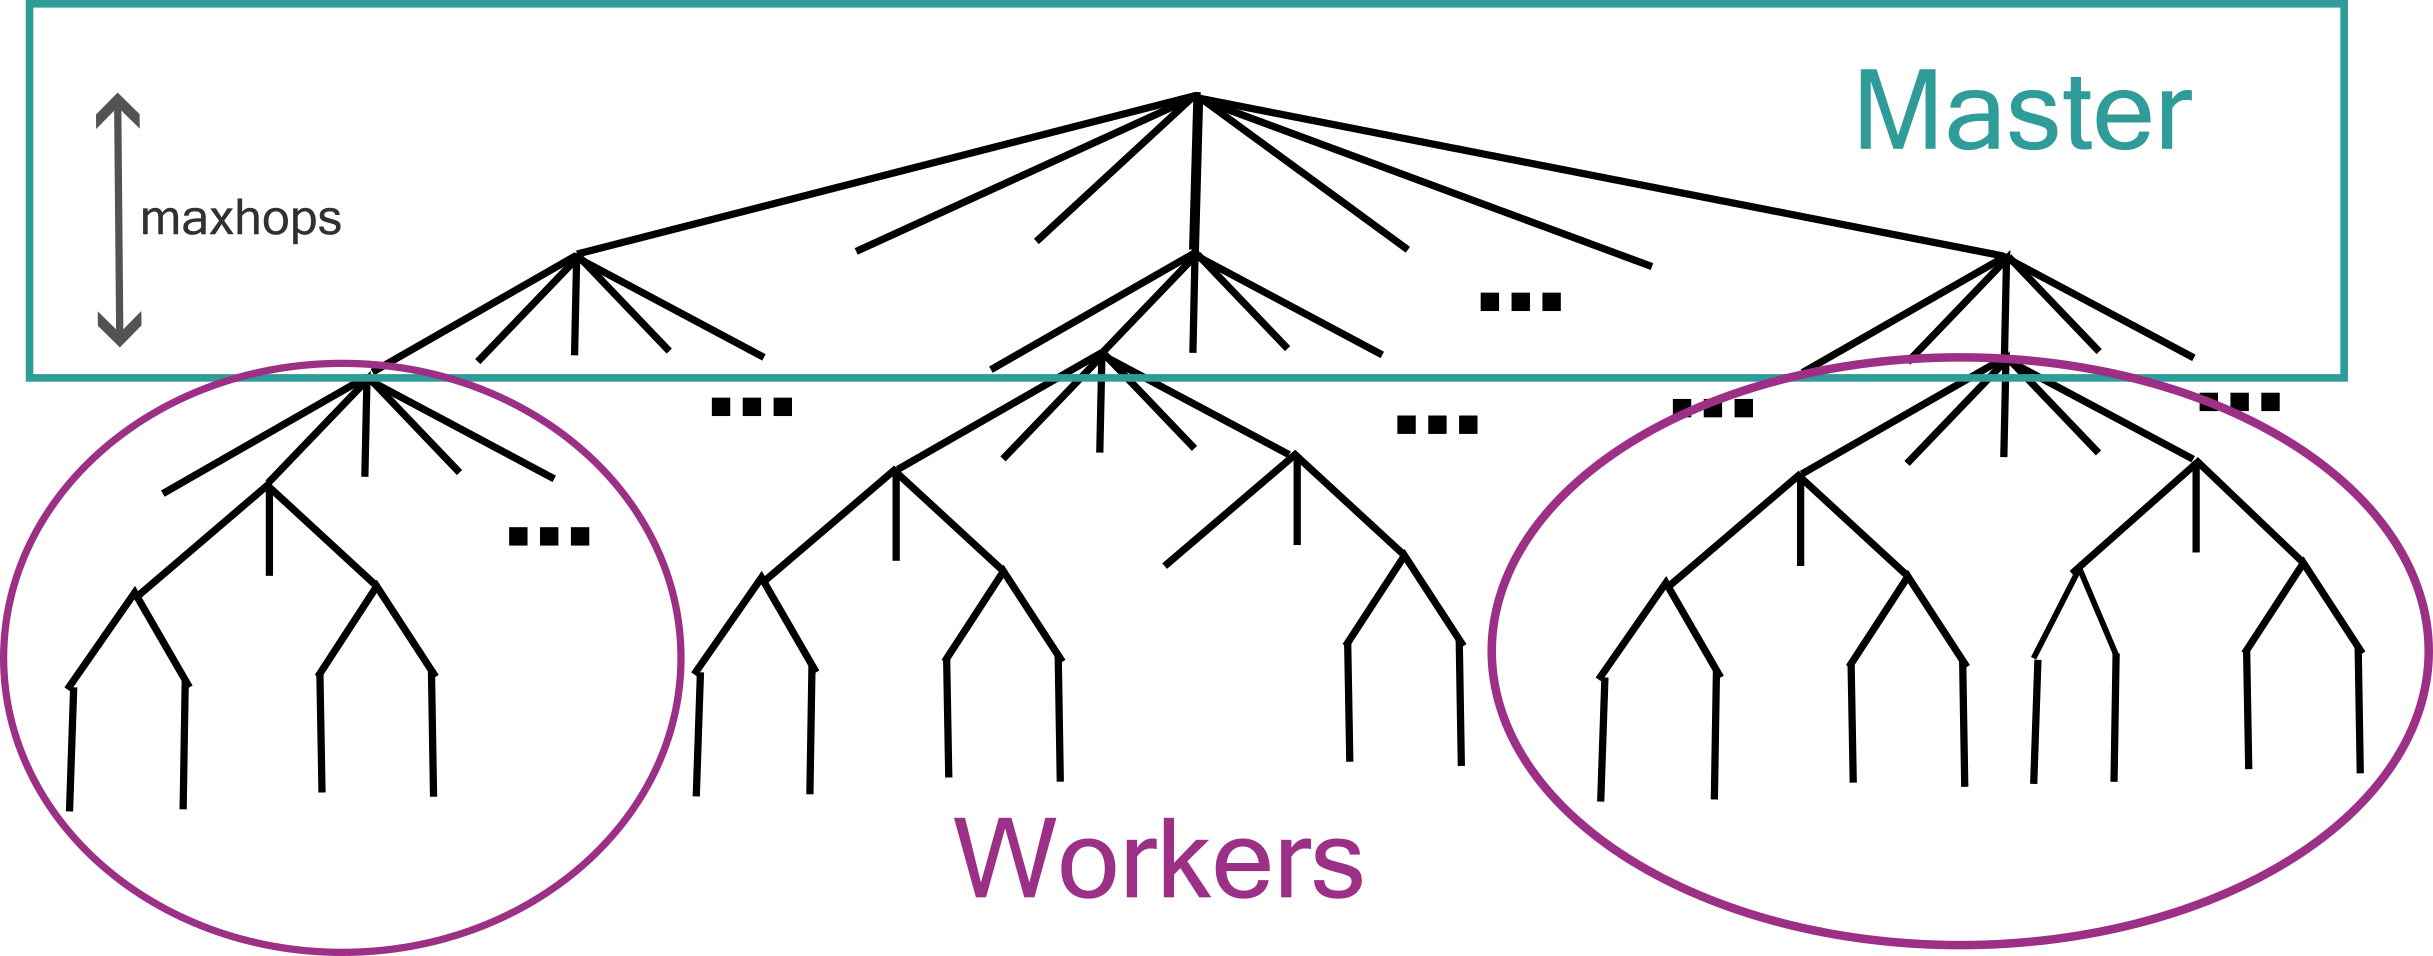


### Simplified example

We will demonstrate how the workers communicate the minimum distance with each other with a short example. Each worker generates a random value and updates a globally shared minimum. The variable for the global minimum is stored in a `RemoteChannel`. The buffer size of the channel is 1, such that only one worker can take and put new values to the channel at a time, thus solving the race condition problem.

In [ ]:
buffer = 1 # Very important
min_distance_chnl = RemoteChannel(()->Channel{Int}(buffer))
put!(min_distance_chnl,typemax(Int))
@sync for w in workers()
    @spawnat w begin
         sleep(rand(1:3))
         min_distance = take!(min_distance_chnl)
         @show min_distance
         distance = rand(5:10)
         @show distance
         min_distance = min(distance,min_distance)
         put!(min_distance_chnl,min_distance)
    end
end
min_distance = take!(min_distance_chnl)
@show min_distance
close(min_distance_chnl)

### Final parallel implementation
Finally, we add the communication of the minimum distance to the first simplified version. Like in the serial implementation, the workers stop the search if the distance of their current path exceeds the global minimum distance. In total, we need two channels: one to communicate the jobs and one to communicate the minimum distance. 

In [ ]:
function tsp_dist(C_sorted,city,max_hops)
    T = typeof((0,Int[],0))
    jobs_chnl = RemoteChannel(()->Channel{T}(1))
    min_distance_chnl = RemoteChannel(()->Channel{Int}(1))
    put!(min_distance_chnl,typemax(Int))
    @sync begin
        for w in workers()
            @spawnat w consume_jobs(C_sorted,jobs_chnl,min_distance_chnl)
        end
        generate_jobs(C_sorted,city,max_hops,jobs_chnl)
        close(jobs_chnl)
    end
    min_distance = take!(min_distance_chnl)
    close(min_distance_chnl)
    return min_distance
end
function generate_jobs(C_sorted,city,max_hops,jobs_chnl)
    num_cities = length(C_sorted)
    path=zeros(Int,num_cities)
    hops = 1
    path[hops] = city
    distance = 0
    generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl,distance)
end
function generate_jobs_recursive(C_sorted,hops,path,max_hops,jobs_chnl,distance)
    num_cities = length(C_sorted)
    if hops == max_hops
        #@show path, distance
        put!(jobs_chnl,(hops,copy(path),distance))
        return nothing
    else
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            next_distance = distance + distance_increment
            if ! already_visited
                path[next_hops] = next_city
                generate_jobs_recursive(
                        C_sorted,next_hops,path,max_hops,jobs_chnl,next_distance)
            end
        end
        return nothing
    end
end
@everywhere function consume_jobs(C_sorted,jobs_chnl,min_distance_chnl)
    while true
        min_distance = take!(min_distance_chnl)
        put!(min_distance_chnl,min_distance)
        try
            hops,path,distance = take!(jobs_chnl)
            consume_jobs_recursive(C_sorted,hops,path,min_distance_chnl,distance,min_distance)
        catch
            break
        end
    end
end
@everywhere function consume_jobs_recursive(C_sorted,hops,path,min_distance_chnl,distance,min_distance)
    if distance >= min_distance
        return min_distance
    end
    num_cities = length(C_sorted)
    if hops != num_cities
        city = path[hops]
        connections = C_sorted[city]
        next_hops = hops + 1
        for (next_city,distance_increment) in connections
            already_visited = (next_city in view(path,1:hops))
            next_distance = distance + distance_increment
            if ! already_visited
                path[next_hops] = next_city
                min_distance = consume_jobs_recursive(
                        C_sorted,next_hops,path,min_distance_chnl,next_distance,min_distance)
            end
        end
        return min_distance
    else
        min_distance = take!(min_distance_chnl)
        min_distance = min(min_distance,distance)
        put!(min_distance_chnl,min_distance)
        #@show path, distance, min_distance
        return min_distance
    end
end

In [ ]:
city = 1
max_hops = 2
min_distance = tsp_dist(C_sorted,city,max_hops)

## Testing the parallel implementation
Next, we will test the correctness and performance of our parallel implementation by comparing the results of the parallel algorithm to the results of the serial algorithm for multiple problem instances. Run it for different values of `n` and `max_hops`. Try to explain the impact of these values on the parallel efficiency.

In [ ]:
n = 18 # Safe to run up to 18 on a laptop
using Random
Random.seed!(1)
C = rand(1:10,n,n)
C_sorted = sort_neighbors(C)
city = 1
verbose = false
T1 = @elapsed min_serial = tsp_serial(C_sorted,city)
max_hops = 2
P = nworkers()
TP = @elapsed min_dist = tsp_dist(C_sorted,city,max_hops)
println("Sequential time = ", T1)
println("Parallel time = ", TP)
println("Speedup = ", T1/TP)
println("Optimal speedup = ", P)
println("Efficiency = ", 100*(T1/TP)/P, "%")
@test min_serial == min_dist

### Super-linear speedup


<div class="alert alert-block alert-success">
<b>Question:</b> For some values of `n` and `max_hops` the parallel efficiency can be above 100% (super-linear speedup). For example with `n=18` and `max_hops=2`, I get super-linear speedup on my laptop for some runs. Explain a possible cause for super-linear speedup in this algorithm.

In [ ]:
uncover = false
q_superlinear_answer(uncover)

## Summary

- We studied the solution of the TSP problem using a branch and bound strategy
- The problem is $O(N!)$ complex in the worse case scenario, where $N$ is the number of cities.
- Luckily, the compute time can be drastically reduced in practice using the nearest city first heuristic and branch pruning.
- Pruning, however, introduces load imbalance in the parallel code. To fix this, one needs a dynamic load balancing strategy as the actual work per worker depends on the input matrix (runtime values).
- A replicated workers model is useful to distribute work dynamically. However, it introduces a trade-off between load balance and communication depending on the value of `maxhops`.
- The parallel code might suffer from positive search overhead (if the optimal route is on the left of the tree) or it can benefit from negative search overhead (if the optimal route is on the right of the tree).
- In some cases, it is possible to observe super-linear speedup thanks to negative search overhead.


# License



This notebook is part of the course [Programming Large Scale Parallel Systems](https://www.francescverdugo.com/XM_40017) at Vrije Universiteit Amsterdam and may be used under a [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/) license.